In [23]:
import numpy as np
from dotenv import load_dotenv
from dwave.system import DWaveSampler, EmbeddingComposite
from numpy import hamming
from openjij import SQASampler
import openjij
from pyqubo import Array, Constraint, LogEncInteger, solve_qubo
import math
import os
import dimod
from minorminer import find_embedding
from dwave.system import FixedEmbeddingComposite
from dwave.embedding import embed_bqm
from dwave.embedding import MinimizeEnergy
from matplotlib import pyplot as plt
import sklearn
import itertools
from copy import copy, deepcopy
import pandas as pd

In [24]:
load_dotenv()

TOKEN = os.getenv("TOKEN")
endpoint = "https://cloud.dwavesys.com/sapi/"
solver = "QA"
num_reads = 1000

In [25]:
W = 750
cost_list = [135,
             139,
             149,
             150,
             156,
             163,
             173,
             184,
             192,
             201,
             210,
             214,
             221,
             229,
             240, ]
weight_list = [70,
               73,
               77,
               80,
               82,
               87,
               90,
               94,
               98,
               106,
               110,
               113,
               115,
               118,
               120, ]
opt = [0,
0,
0,
0,
0,
0,
1,
0,
0,
0,
1,
0,
1,
1,
0,
0,
0,
0,
0,
0,
0,
0,
0,
1,
0,
1,
0,
0,
0,
0,
1,
0,
1,
0,
0,
0,
0,
1,
1,
0,
0,
0,
0,
0,
0,
0,
0,
0,
1,
0,]
N = len(cost_list)

In [26]:
x = Array.create('x', shape=(N), vartype='BINARY')
y = LogEncInteger("y", (0, W))

In [27]:
# key1 = max(cost_list, key=lambda k: cost_list[k])
max_c = max(cost_list)
B = 1
A = B * max_c * 2

In [28]:
HA = Constraint(
    A * (W - sum(weight_list[a] * x[a] for a in range(N)) - y)**2, label='HA'
)

HB = - B * sum(cost_list[a] * x[a] for a in range(N))

In [29]:
H = HA + HB
model = H.compile()
Q, offset = model.to_qubo()

In [30]:
if solver == "QA":
    dw_sampler = DWaveSampler(solver='Advantage_system6.1',
                            token=TOKEN, endpoint=endpoint)
    adj = {}
    for k in Q.keys():
        adj[k] = 1
    embedding = find_embedding(adj, dw_sampler.edgelist)
    # bqm_embed = embed_bqm(bqm, embedding, dw_sampler.adjacency)
    sampler = FixedEmbeddingComposite(dw_sampler, embedding)
    # sampler = EmbeddingComposite(dw_sampler)
    # sampleset_embed = dw_sampler.sample(bqm_embed, num_reads=10)
    print("setting DW sampler")
else:
    sampler = SQASampler(num_reads=num_reads)
    print("setting SQA sampler")

setting DW sampler


In [108]:
t = [(0,   100)]
s = [(0, 1)]

schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(schedules)


[[(0, 0), (100, 1)]]


In [109]:
def plot_schedules(t, s, save_path="output.jpg", title=None):
    fig, ax = plt.subplots(1, len(t))
    if len(t) == 1:
        ax = [ax]
    fig.set_figwidth(5 * len(t))
    for i in range(len(t)):
        ax[i].plot(t[i], s[i])
        ax[i].set_xlim(-1.0, t[i][-1] + 1.)
        ax[i].set_ylim(-0.1, 1.1)
        if not title == None:
            ax[i].set_title(title[i].upper())

    plt.tight_layout()
    plt.savefig(save_path)

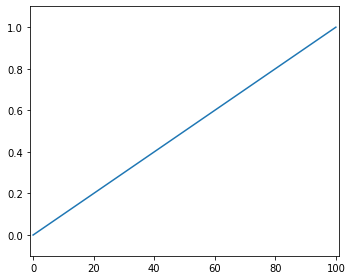

In [110]:
plot_schedules(t, s, "anneal_schedule.jpg")

In [111]:
samplesets = []
for schedule in schedules:
    print("annealing start")
    if solver == "QA":
        samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule))
    else:
        samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")

annealing start
annealing end


In [112]:
def dict_from_sampleview(sampleview):
    d = {}

    for key in sampleview.keys():
        d[key] = sampleview.get(key)
    
    return d

In [113]:
def transform_sample(sampleset, schedule, model):
    # decoded_samples = model.decode_sampleset(
    #     sampleset=sampleset, vartype="BINARY")
    decoded_samples = []
    for sample, record in zip(sampleset, sampleset.record):
        decoded_sample = model.decode_sample(
            dict_from_sampleview(sample), vartype="BINARY")
        decoded_samples.append((decoded_sample, record[1]))

    value_set = []
    for decoded_sample, energy in decoded_samples:
        cost = 0
        weight = 0
        for k in range(N):
            if decoded_sample.array('x', k) != 0:
                cost += cost_list[k]
                weight += weight_list[k]

        sol_y = sum(2**k * v for k, v in [(elem, decoded_sample.array('y', elem))
                                          for elem in range(math.ceil(math.log2(W)))])

        value_set.append(
            {"cost": cost, "weight": weight, "energy": energy, "sol_y": sol_y, "broken": decoded_sample.constraints(only_broken=True)})

    value_df = pd.DataFrame(value_set)
    value_df_sorted_cost = value_df[value_df["weight"] <= W].sort_values(by=[
                                                                    "cost"])
    value_max = value_df_sorted_cost.loc[value_df_sorted_cost["cost"].idxmax()]
    value_min = value_df_sorted_cost.loc[value_df_sorted_cost["cost"].idxmin()]
    
    # value_df_sorted_by_energy = value_df.sort_values(by=["energy"])

    return {"anneal_time": sampleset.info["timing"]["qpu_anneal_time_per_sample"], "anneal_schedule": schedule, "info_sets": value_set, "best_value": value_max, "worst_value": value_min, "dataframe": value_df}


def v_transform_sample(samplesets, schedules, model):
    if type(samplesets) == list:
        sample_info = []
        for (sampleset, schedule) in zip(samplesets, schedules):
            sample_info.append(transform_sample(sampleset, schedule, model))
        return sample_info
    else:
        return transform_sample(transform_sample(samplesets, schedules, model))


In [114]:
def output_sample_info(sample_info):
    print("anneal time = {}".format(sample_info["anneal_time"]))
    print("anneal schedule = {}".format(sample_info["anneal_schedule"]))
    print("----- best ------")
    print("slack_Y = {}".format(sample_info["best_value"]["sol_y"]))
    print("broken: {}".format(sample_info["best_value"]["broken"]))
    print("cost : "+str(sample_info["best_value"]["cost"]))
    print("weight : "+str(sample_info["best_value"]["weight"]))
    print("-----------------")
    print("----- worst -----")
    print("slack_Y = {}".format(sample_info["worst_value"]["sol_y"]))
    print("broken: {}".format(sample_info["worst_value"]["broken"]))
    print("cost : "+str(sample_info["worst_value"]["cost"]))
    print("weight : "+str(sample_info["worst_value"]["weight"]))
    print("-----describe----")
    print("describe")
    print(sample_info["dataframe"].describe())
    print()

def v_output_sample_info(samples_info):
    if type(samples_info) == list:
        for sample_info in samples_info:
            output_sample_info(sample_info)
    else:
        output_sample_info(samples_info)

In [115]:
sample_info = v_transform_sample(samplesets, schedules, model)
v_output_sample_info(sample_info)


anneal time = 100.0
anneal schedule = [(0, 0), (100, 1)]
----- best ------
slack_Y = 268
broken: {'HA': (False, 34475520.0)}
cost : 1441
weight : 750
-----------------
----- worst -----
slack_Y = 866
broken: {'HA': (False, 3072000.0)}
cost : 458
weight : 237
-----describe----
describe
              cost      weight        energy       sol_y
count   881.000000  881.000000  8.810000e+02  881.000000
mean   1036.692395  539.263337 -2.475153e+08  532.282633
std     187.777648   97.611957  2.787638e+07  261.251565
min     458.000000  237.000000 -2.700014e+08    1.000000
25%     919.000000  477.000000 -2.675127e+08  297.000000
50%    1058.000000  550.000000 -2.608599e+08  584.000000
75%    1137.000000  593.000000 -2.344885e+08  835.000000
max    1698.000000  883.000000 -1.012100e+08  902.000000



## リバースアニーリング

In [116]:
init = samplesets[0].samples()[-1]

In [117]:
t = [(0, 10, 100)]
s = [(1.0, 0.2, 1.0)]

reverse_schedules = [list(zip(t[i], s[i])) for i in range(len(t))]
print(reverse_schedules)


[[(0, 1.0), (10, 0.2), (100, 1.0)]]


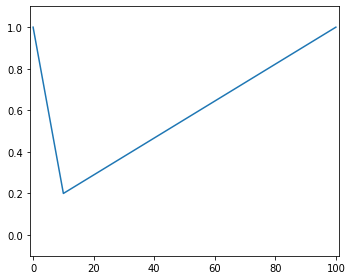

In [118]:
plt.close()
plot_schedules(t, s, "reverse_anneal.jpg")


In [119]:
reverse_samplesets = []
for schedule in reverse_schedules:
    print("annealing start")
    if solver == "QA":
        reverse_samplesets.append(sampler.sample_qubo(
            Q, num_reads=num_reads, anneal_schedule=schedule, initial_state=init))
    else:
        reverse_samplesets.append(sampler.sample_qubo(Q))
    print("annealing end")


annealing start
annealing end


In [120]:
reverse_sample_info = v_transform_sample(reverse_samplesets, reverse_schedules, model)
v_output_sample_info(reverse_sample_info)


anneal time = 100.0
anneal schedule = [(0, 1.0), (10, 0.2), (100, 1.0)]
----- best ------
slack_Y = 160
broken: {'HA': (False, 11831520.0)}
cost : 1437
weight : 747
-----------------
----- worst -----
slack_Y = 881
broken: {'HA': (False, 554880.0)}
cost : 336
weight : 176
-----describe----
describe
              cost       weight        energy       sol_y
count  1000.000000  1000.000000  1.000000e+03  1000.00000
mean   1007.452000   524.040000 -2.273087e+08   733.12200
std     155.497129    81.186992  3.194793e+07   190.05762
min     336.000000   176.000000 -2.700008e+08    50.00000
25%     837.000000   435.000000 -2.586174e+08   603.00000
50%    1038.000000   541.000000 -2.346188e+08   840.00000
75%    1058.000000   550.000000 -2.046438e+08   849.00000
max    1443.000000   754.000000 -1.397096e+08   891.00000



In [ ]:
t = [(0, 20), (0, 5, 15, 20), (0, 5, 6, 20), (0, 9, 10, 20), (0, 19, 20)]
s = [(0, 1), (0, 0.5, 0.5, 1), (0, 0.5, 1, 1), (0, 0.5, 1, 1), (0, 0.5, 1)]
plot_schedules(t, s, "pause_quench_schedule.jpg", [
               "std", "pause", "quench A", "quench B", "quench C"])

t = [(0, 5, 15, 20), (0, 5, 15, 20)]
s = [(1.0, 0.4, 0.4, 1.0), (1, 0.2, 0.2, 1.0)]
plot_schedules(t, s, "reverse_anneal.jpg", [
               "reverse A", "reverse B"])
